# Instalação das bibliotecas

In [66]:
# Instalação necessária
!pip install -q kaggle
!pip install -q scikit-image

# Importação das bibliotecas

In [67]:
import os
import zipfile
import numpy as np
import cv2
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.losses import mse
import tensorflow.keras.backend as K
from skimage.metrics import structural_similarity as ssim
from tensorflow.image import ssim_multiscale
import matplotlib.pyplot as plt
import time

# Download do dataset
>Deve-se gerar o arquivo kaggle.json no site
>https://www.kaggle.com/

In [68]:
from google.colab import files
uploaded = files.upload()

# Criar diretório e mover o kaggle.json
os.makedirs('/root/.kaggle', exist_ok=True)
with open('/root/.kaggle/kaggle.json', 'wb') as f:
    f.write(uploaded['kaggle.json'])

os.chmod('/root/.kaggle/kaggle.json', 0o600)

# Baixar o dataset SARD 2
!kaggle datasets download -d nikolasgegenava/sard-2-search-and-rescue-dataset-extra-classes
!unzip -q sard-2-search-and-rescue-dataset-extra-classes.zip -d sard2

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/nikolasgegenava/sard-2-search-and-rescue-dataset-extra-classes
License(s): MIT
sard-2-search-and-rescue-dataset-extra-classes.zip: Skipping, found more recently modified local copy (use --force to force download)
replace sard2/search-and-rescue-2/README.dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


# Pré-processamento carregamento das imagens

In [69]:
def carregar_imagens(pasta, tamanho=(128, 128), max_imgs=3000):
    imagens = []
    for img_nome in tqdm(os.listdir(pasta)[:max_imgs]):
        img_path = os.path.join(pasta, img_nome)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img is not None:
            img = cv2.resize(img, tamanho)
            img = img.astype('float32') / 255.0
            imagens.append(img)
    return np.array(imagens)

X_train = carregar_imagens('sard2/search-and-rescue-2/train/images')
X_val   = carregar_imagens('sard2/search-and-rescue-2/valid/images')
X_test  = carregar_imagens('sard2/search-and-rescue-2/test/images')

100%|██████████| 198/198 [00:02<00:00, 67.77it/s]


# Definição dos Modelos de Autoencoders

In [70]:
# 1) Autoencoder Convencional
def criar_autoencoder(input_shape=(128,128,3)):
    inp = Input(shape=input_shape, name='conv_input')
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inp)
    x = layers.MaxPooling2D(2, padding='same')(x)
    x = layers.Conv2D(16, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2, padding='same')(x)
    x = layers.Conv2D(16, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(16, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D(2)(x)
    out = layers.Conv2D(3, 3, activation='sigmoid', padding='same')(x)

    autoenc = Model(inp, out, name='autoencoder_conv')
    autoenc.compile(optimizer='adam', loss='mse')
    return autoenc


# 2) Autoencoder Variacional
def criar_vae(input_shape=(128,128,3), latent_dim=64):
    # Encoder
    inputs = Input(shape=input_shape, name='encoder_input')
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(2, padding='same')(x)
    x = layers.Conv2D(16, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2, padding='same')(x)
    flat = layers.Flatten()(x)

    mu      = layers.Dense(latent_dim, name='mu')(flat)
    log_var = layers.Dense(latent_dim, name='log_var')(flat)

    # Sampling via Lambda layer
    def sampling(args):
        mu, log_var = args
        eps = K.random_normal(shape=K.shape(mu))
        return mu + K.exp(0.5 * log_var) * eps

    z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([mu, log_var])

    # Decoder
    dec_in = Input(shape=(latent_dim,), name='decoder_input')
    y = layers.Dense(32*32*16, activation='relu')(dec_in)
    y = layers.Reshape((32,32,16))(y)
    y = layers.UpSampling2D(2)(y)
    y = layers.Conv2D(16, 3, activation='relu', padding='same')(y)
    y = layers.UpSampling2D(2)(y)
    decoded = layers.Conv2D(3, 3, activation='sigmoid', padding='same')(y)

    decoder = Model(dec_in, decoded, name='decoder')
    outputs = decoder(z)
    vae = Model(inputs, outputs, name='vae')

    vae.compile(optimizer='adam', loss=mse)
    return vae


# 3) Autoencoder com penalização de redundância
def criar_autoencoder_redundancia(input_shape=(128,128,3)):
    inp = Input(shape=input_shape, name='pen_input')
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inp)
    x = layers.MaxPooling2D(2, padding='same')(x)
    x = layers.Conv2D(16, 3, activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D(2, padding='same')(x)

    flat = layers.Flatten()(encoded)
    penal = layers.Dense(
        256,
        activity_regularizer=tf.keras.regularizers.l1(1e-5),
        name='encoded_penalizado'
    )(flat)

    x = layers.Dense(32*32*16, activation='relu')(penal)
    x = layers.Reshape((32,32,16))(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(16, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D(2)(x)
    out = layers.Conv2D(3, 3, activation='sigmoid', padding='same')(x)

    autoenc_pen = Model(inp, out, name='autoencoder_redundancia')
    autoenc_pen.compile(optimizer='adam', loss='mse')
    return autoenc_pen

# Treinamento e avaliação

In [71]:
def treinar_e_avaliar(modelo, nome):
    modelo.fit(X_train, X_train, epochs=5, batch_size=32, validation_data=(X_val, X_val), verbose=0)
    psnr_total, ssim_total, ms_ssim_total, tempo_total = 0, 0, 0, 0
    for i in range(50):
        entrada = np.expand_dims(X_test[i], axis=0)
        inicio = time.time()
        saida = modelo.predict(entrada, verbose=0)
        fim = time.time()
        tempo_total += fim - inicio
        psnr_total += tf.image.psnr(entrada, saida, max_val=1.0).numpy()[0]
        ssim_total += ssim(entrada[0], saida[0], data_range=1.0, channel_axis=2)
        ms_ssim_total += tf.image.ssim_multiscale(
            entrada, saida,
            max_val=1.0,
            filter_size=3
        ).numpy()[0]
    return psnr_total/50, ssim_total/50, ms_ssim_total/50, tempo_total/50

modelos = {
    'Convencional': criar_autoencoder(),
    'Variacional': criar_vae(),
    'Redundância': criar_autoencoder_redundancia()
}

resultados = {}
for nome, modelo in modelos.items():
    print(f'Treinando {nome}...')
    resultados[nome] = treinar_e_avaliar(modelo, nome)


Treinando Convencional...
Treinando Variacional...
Treinando Redundância...


# Análise de resultados

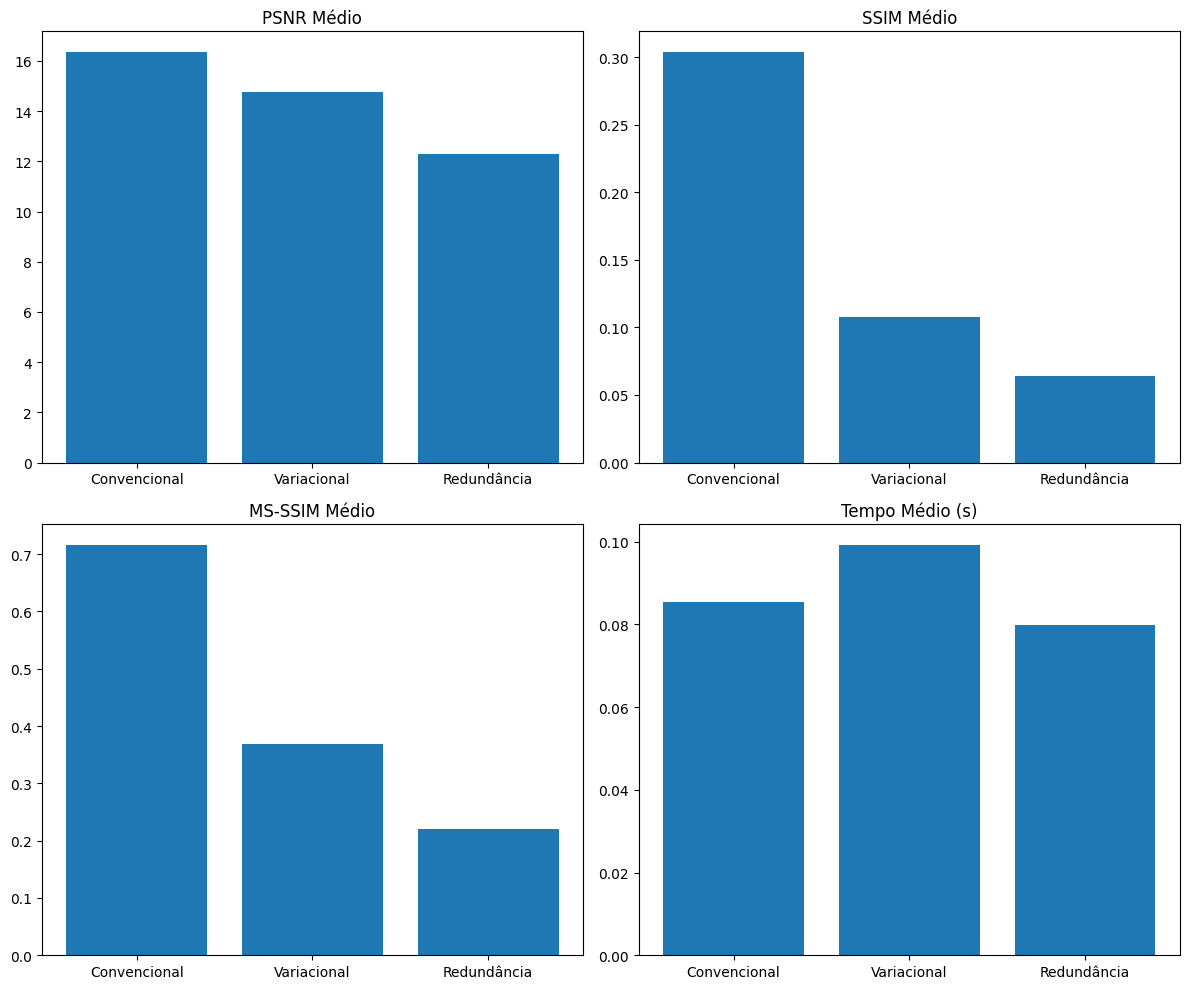

In [72]:
import matplotlib.pyplot as plt

labels       = list(resultados.keys())
psnr_vals    = [resultados[n][0] for n in labels]
ssim_vals    = [resultados[n][1] for n in labels]
ms_ssim_vals = [resultados[n][2] for n in labels]
tempo_vals   = [resultados[n][3] for n in labels]

# Cria um grid 2x2
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=False)

# Desenrola os eixos em uma lista para indexar facilmente
axs = axes.flatten()

# Plota cada métrica
axs[0].bar(labels, psnr_vals)
axs[0].set_title('PSNR Médio')

axs[1].bar(labels, ssim_vals)
axs[1].set_title('SSIM Médio')

axs[2].bar(labels, ms_ssim_vals)
axs[2].set_title('MS-SSIM Médio')

axs[3].bar(labels, tempo_vals)
axs[3].set_title('Tempo Médio (s)')

plt.tight_layout()
plt.show()


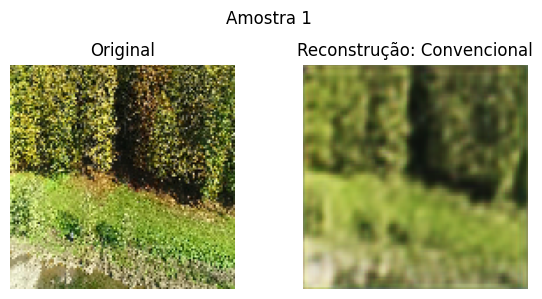

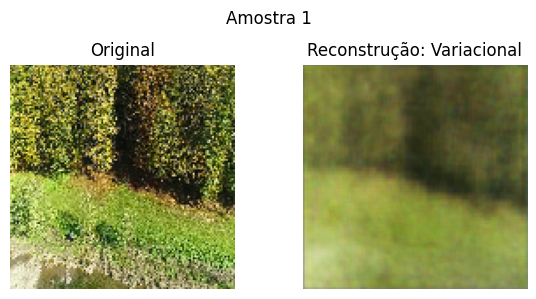

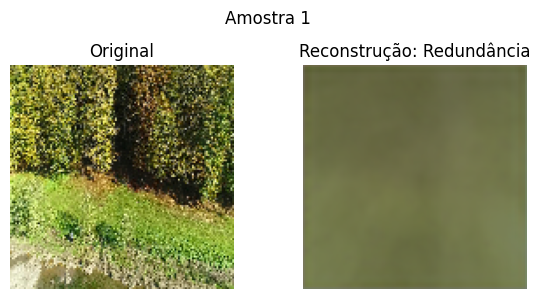

In [76]:
def mostrar_reconstrucao(idx):
    orig = X_test[idx]
    entrada = orig[np.newaxis]

    for nome, modelo in modelos.items():
        recon = modelo.predict(entrada, verbose=0)[0]

        plt.figure(figsize=(6,3))
        plt.subplot(1,2,1)
        plt.imshow(orig)
        plt.title('Original')
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.imshow(recon)
        plt.title(f'Reconstrução: {nome}')
        plt.axis('off')

        plt.suptitle(f'Amostra {idx}')
        plt.tight_layout()
        plt.show()

# Exemplo de uso
mostrar_reconstrucao(1)


In [78]:
from scipy.stats import kruskal

# 1) Função auxiliar que retorna as listas de métricas para um modelo
def coletar_metricas(modelo, n_amostras=50):
    psnr_list    = []
    ssim_list    = []
    ms_ssim_list = []

    # já treinou antes, mas podemos retreinar rápido para alinhar com o split
    modelo.fit(
        X_train, X_train,
        epochs=5, batch_size=32,
        validation_data=(X_val, X_val),
        verbose=0
    )

    for i in range(n_amostras):
        entrada = np.expand_dims(X_test[i], axis=0)
        saida   = modelo.predict(entrada, verbose=0)

        # acumula cada valor
        psnr_list.append(
            tf.image.psnr(entrada, saida, max_val=1.0).numpy()[0]
        )
        ssim_list.append(
            ssim(entrada[0], saida[0], data_range=1.0, channel_axis=2)
        )
        ms_ssim_list.append(
            tf.image.ssim_multiscale(
                entrada, saida,
                max_val=1.0,
                filter_size=3
            ).numpy()[0]
        )

    return psnr_list, ssim_list, ms_ssim_list

# 2) Coleta as métricas para cada modelo
psnr_conv, ssim_conv, ms_ssim_conv = coletar_metricas(modelos['Convencional'])
psnr_var,  ssim_var,  ms_ssim_var  = coletar_metricas(modelos['Variacional'])
psnr_red,  ssim_red,  ms_ssim_red  = coletar_metricas(modelos['Redundância'])

# 3) Teste de Kruskal-Wallis em cada métrica
stat_psnr, p_psnr   = kruskal(psnr_conv, psnr_var, psnr_red)
stat_ssim, p_ssim   = kruskal(ssim_conv, ssim_var, ssim_red)
stat_msss, p_msss   = kruskal(ms_ssim_conv, ms_ssim_var, ms_ssim_red)

print("Kruskal-Wallis Results:")
print(f"  PSNR   → H = {stat_psnr:.3f}, p = {p_psnr:.4f}")
print(f"  SSIM   → H = {stat_ssim:.3f}, p = {p_ssim:.4f}")
print(f"  MS-SSIM→ H = {stat_msss:.3f}, p = {p_msss:.4f}")



Kruskal-Wallis Results:
  PSNR   → H = 101.699, p = 0.0000
  SSIM   → H = 107.259, p = 0.0000
  MS-SSIM→ H = 121.603, p = 0.0000
